# ODEs: Damped driven pendulum

We are now going to investigate a damped driven pendulum. The equations of motion for a pendulum with length $L$ and mass $m$, with damping coefficient $b$, undergoing forced motion with magnitude $F_D$ and driving frequency $\omega_D$ are

$$
\frac{d^2\theta}{dt^2} = -\omega_0^2 \sin(\theta) - \Gamma \frac{d\theta}{dt} + F_D \cos(\omega_D t)
$$

where $\omega_0 = \sqrt{g/L}$ (with $g$ being the gravitational constant) and $\Gamma = b/2m$. 

For small oscillations, the analytic steady-state solution is

$$
\theta(t) = \frac{F_D \cos(\omega_D t + \phi)}{\sqrt{(\omega_0^2 - \omega_D^2)^2 + (\Gamma \omega_D)^2}}
$$

However, this fails for large angles because it is a nonlinear oscillator. For that we will need numeric solutions. 

For all cases, it is insufficient to utilize the [Euler](https://en.wikipedia.org/wiki/Euler_method), [Euler-Cromer](https://en.wikipedia.org/wiki/Semi-implicit_Euler_method), or [Midpoint](https://en.wikipedia.org/wiki/Midpoint_method) methods to achieve stable orbits. We will investigate the use of the [Verlet](https://en.wikipedia.org/wiki/Verlet_integration) scheme:

$$
\vec{v}_n = \frac{\vec{r}_{n+1} - \vec{r}_{n-1}}{2\tau} + \mathcal{O}(\tau^2)
$$

$$
\vec{x}_n = 2\vec{x}_n - \vec{x}_{n-1} + \tau^2 \vec{a}_n
$$


We are going to start here to use the official `scipy` ODE integration tools. This is because the "native python" implementation from previous notebooks is very slow and we need a lot of computations. It is indeed possible to write our own `C++` implementation and put it into `python` via `swig`, but in this case the `scipy` functions perform well. 

The function we will use is [solve_ivp](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html). 


For more details on the nonlinear pendulum see [here](https://www.thphys.uni-heidelberg.de/~gasenzer/index.php?n1=teaching&n2=chaos). 

In [154]:
import os
import numpy as np
import matplotlib
matplotlib.rcParams['legend.fancybox'] = True
import matplotlib.pyplot as plt
import scipy.integrate
import concurrent
import time
from pprint import pprint

## Set initial conditions and initialize trajectory

In [48]:
# Define a few parameters to check some typical trajectories. 

params_linear = {
    'method':'RK45',
    'tmax':200.,
    'theta_init':0.1,
    'omega_init':0.0,
    'gamma':0.0,
    'omega0':1.0,
    'F_D':0,
    'omegaD':0
}
params_twocycle ={
    'method':'RK45',
    'tmax':200.,
    'theta_init':0.0,
    'omega_init':0.0,
    'gamma':0.5,
    'omega0':1.0,
    'F_D':1.07,
    'omegaD':2/3
}
params_chaos ={
    'method':'RK45',
    'tmax':2000.,
    'theta_init':0.0,
    'omega_init':0.0,
    'gamma':0.5,
    'omega0':1.0,
    'F_D':1.15,
    'omegaD':2/3
}

## Implement a "Pendulum" class.

This class implements the derivative of the state vector. This is another example of a "functor": a class that implements a `()` method, so you can use it like a function, but also use class variables to store a "state" of the function. We implement everything in a vectorized way, which will drastically speed up our computation in `solve_ivp` below. This will also accept all of the parameters in the dictionary that is passed to it and use `setattr` to create data members. 

In [49]:
class Pendulum:
    def __init__ (self, 
                 gamma: float, 
                 omega_0: float, 
                 F_D: float, 
                 omega_D: float):
        self.gamma = gamma
        self.omega_0 = omega_0
        self.F_D = F_D
        self.omega_D = omega_D

    def __call__(self, t, state):
        flow = np.zeros_like(state)
        flow[0] = state[1]
        flow[1] = -self.omega_0**2 * np.sin(state[0]) - self.gamma * state[1] + self.F_D * np.cos(self.omega_D * t)    
        return flow

## Simulate and plot the trajectories

In [73]:
# Chaotic pendulum
tmax = 2000.
theta_init = 0.0
omega_init = 0.0
method = "RK45"
pendul = {}
pendul["chaos"] = Pendulum(
    gamma = 0.5,
    omega_0 = 1.0, # natural frequency, not initial value!
    F_D = 1.15,
    omega_D = 2/3
)
res = scipy.integrate.solve_ivp(fun = pendul["chaos"],
                                t_span = (0., tmax),
                                y0 = [theta_init, omega_init], 
                                vectorized = True, 
                                atol = 1e-8,
                                rtol = 1e-6,
                                method = method,
                                first_step = 0.001)
# Results storage
t = {}
states = {}
theta = {}
omega = {}
t["chaos"] = res.t
states["chaos"] = res.y
theta["chaos"] = states["chaos"][0]
omega["chaos"] = states["chaos"][1]

Text(0, 0.5, '$\\omega(t)$ (radians)')

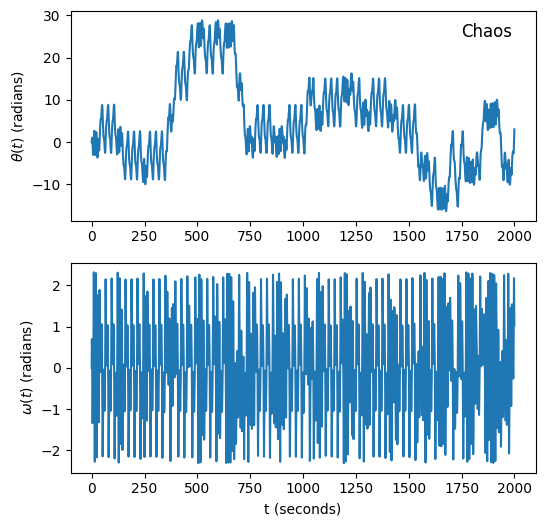

In [74]:
fig, ax = plt.subplots(2, 1, figsize=(6, 6))
ax[0].plot(t["chaos"], theta["chaos"])
ax[0].set_ylabel(r"$\theta(t)$ (radians)")
ax[0].text(1750, 25, "Chaos", size="large")

ax[1].plot(t["chaos"], omega["chaos"])
ax[1].set_xlabel("t (seconds)")
ax[1].set_ylabel(r"$\omega(t)$ (radians)")


In [75]:
# Linear pendulum
tmax = 200.
theta_init = 0.1
omega_init = 0.0
method = "RK45"
pendul["linear"] = Pendulum(
    gamma = 0.0, 
    omega_0 = 1.0, 
    F_D = 0.0, 
    omega_D = 0.0
)

res = scipy.integrate.solve_ivp(fun = pendul["linear"],
                                t_span = (0., tmax),
                                y0 = [theta_init, omega_init], 
                                vectorized = True, 
                                atol = 1e-8,
                                rtol = 1e-6,
                                method = method,
                                first_step = 0.001)
t["linear"] = res.t
states["linear"] = res.y
theta["linear"] = states["linear"][0]
omega["linear"] = states["linear"][1]

Text(0, 0.5, '$\\omega(t)$ (radians)')

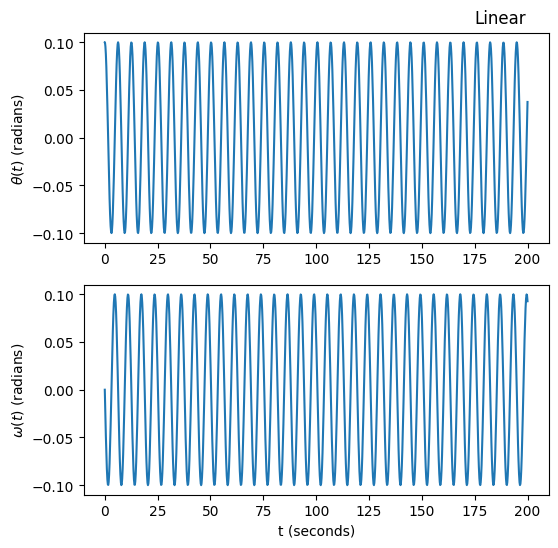

In [76]:
fig, ax = plt.subplots(2, 1, figsize=(6, 6))
ax[0].plot(t["linear"], theta["linear"])
ax[0].set_ylabel(r"$\theta(t)$ (radians)")
ax[0].text(175, 0.12, "Linear", size="large")

ax[1].plot(t["linear"], omega["linear"])
ax[1].set_xlabel("t (seconds)")
ax[1].set_ylabel(r"$\omega(t)$ (radians)")


In [77]:
# 2-cycle pendulum
tmax = 200.
theta_init = 0.1
omega_init = 0.0
method = "RK45"
pendul["twocycle"] = Pendulum(
    gamma = 0.5, 
    omega_0 = 1.0, 
    F_D = 1.07, 
    omega_D = 2./3
)

res = scipy.integrate.solve_ivp(fun = pendul["twocycle"],
                                t_span = (0., tmax),
                                y0 = [theta_init, omega_init], 
                                vectorized = True, 
                                atol = 1e-8,
                                rtol = 1e-6,
                                method = method,
                                first_step = 0.001)
t["twocycle"] = res.t
states["twocycle"] = res.y
theta["twocycle"] = states["twocycle"][0]
omega["twocycle"] = states["twocycle"][1]

Text(0, 0.5, '$\\omega(t)$ (radians)')

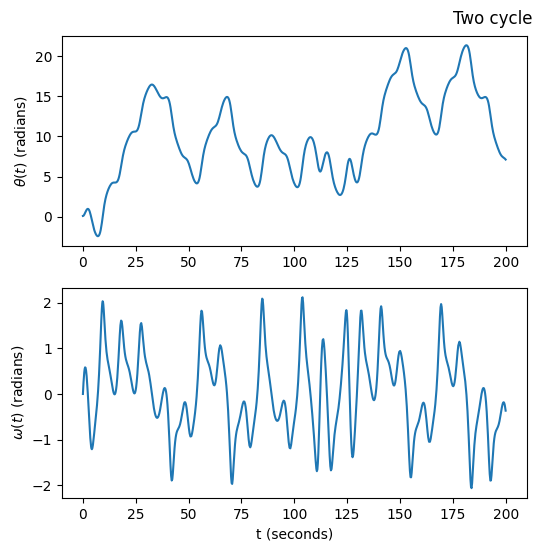

In [78]:
fig, ax = plt.subplots(2, 1, figsize=(6, 6))
ax[0].plot(t["twocycle"], theta["twocycle"])
ax[0].set_ylabel(r"$\theta(t)$ (radians)")
ax[0].text(175, 24, "Two cycle", size="large")

ax[1].plot(t["twocycle"], omega["twocycle"])
ax[1].set_xlabel("t (seconds)")
ax[1].set_ylabel(r"$\omega(t)$ (radians)")


## Define a Poincare map

Now we will define a Poincare map defined by the steady-state period. If there is no driving force, this will be the period corresponding to the natural frequency $\omega_0$. If there is a driving force, it is the period corresponding to the driving frequency $\omega_D$. 

The Poincare section will be the state vector (in this case, $(\theta, \omega)$), evaluated after each period has elapsed. We already have the entire time series (plotted above), so we just need to do some array programming to get the values we need. 

We will first "wrap" the angle $\theta$ from $\left(-\pi, \pi\right]$. We will also ignore the transients by removing times below a threshold (in this case, we require $t > 100$ s). The Poincare map is therefore constructed by the state vector at each period, as described below. 


In [82]:
theta1 = {}
for case in ["linear", "twocycle", "chaos"]:
    if pendul[case].omega_D > 0.0:
        T_p = 2*np.pi / pendul[case].omega_D
    else:
        T_p = 2*np.pi / pendul[case].omega_0
    
    
    theta1[case] = (theta[case] + np.pi) % (2 * np.pi ) - np.pi

### Plot wrapped angle time series

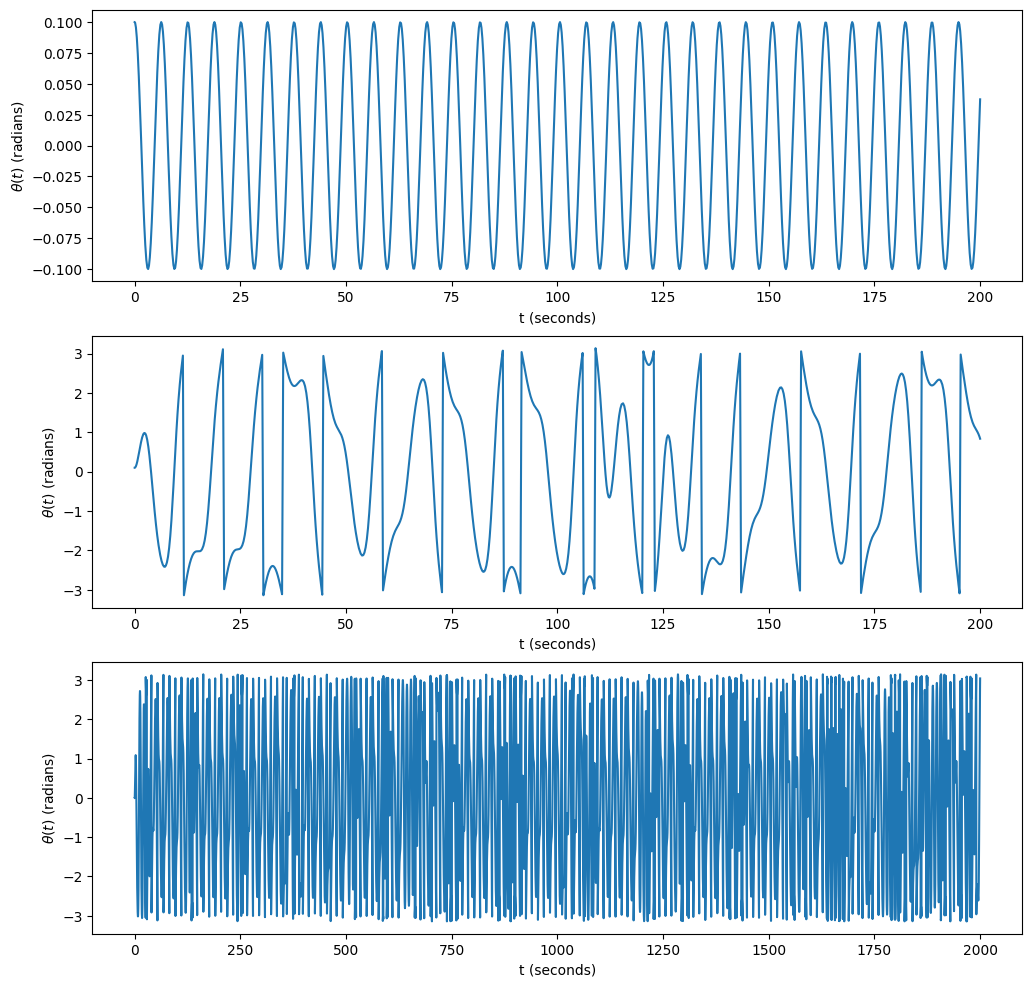

In [85]:
fig, ax = plt.subplots(3, 1, figsize=(12, 12))
for i, case in enumerate(["linear", "twocycle", "chaos"]):
    ax[i].plot(t[case], theta1[case])
    ax[i].set_xlabel("t (seconds)")
    ax[i].set_ylabel(r"$\theta(t)$ (radians)")


### Plot trajectory (ignoring transients)

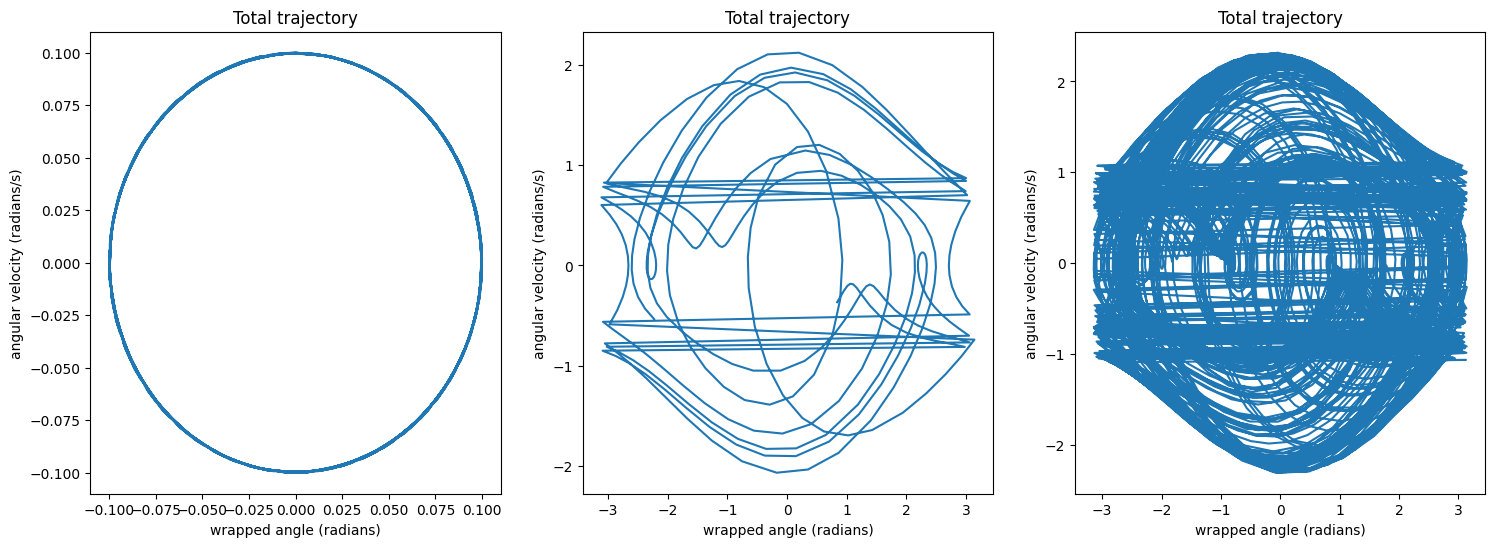

In [87]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
transient_mask = {}
for i, case in enumerate(["linear", "twocycle", "chaos"]):
    transient_mask[case] = t[case][1:] > 100.
    ax[i].plot(theta1[case][1:][transient_mask[case]], omega[case][1:][transient_mask[case]])
    ax[i].set_title("Total trajectory")
    ax[i].set_xlabel(r"wrapped angle (radians)")
    ax[i].set_ylabel(r"angular velocity (radians/s)")


### Plot the Poincare section itself 

To get the number of periods elapsed ("period number" $t/T_p$), we divide the time by the period with "floor division". This also conveniently works for floating point numbers in `python`! We can then look at $t_i/T_p$ and compare to $t_{i-1}/T_p$. If the previous period number is different from this period number, we are at the desired point for the Poincare map. 

In [90]:
poincaremap = {}
ptheta = {}
pomega = {}

for case in ["linear", "twocycle", "chaos"]:
    if pendul[case].omega_D > 0.0:
        T_p = 2*np.pi / pendul[case].omega_D
    else:
        T_p = 2*np.pi / pendul[case].omega_0

    poincaremap[case] = ( (t[case][1:] // T_p) - (t[case][0:-1] // T_p) ) > 0.
    ptheta[case] = theta1[case][1:][poincaremap[case] & transient_mask[case]]
    pomega[case] = omega[case][1:][poincaremap[case] & transient_mask[case]]

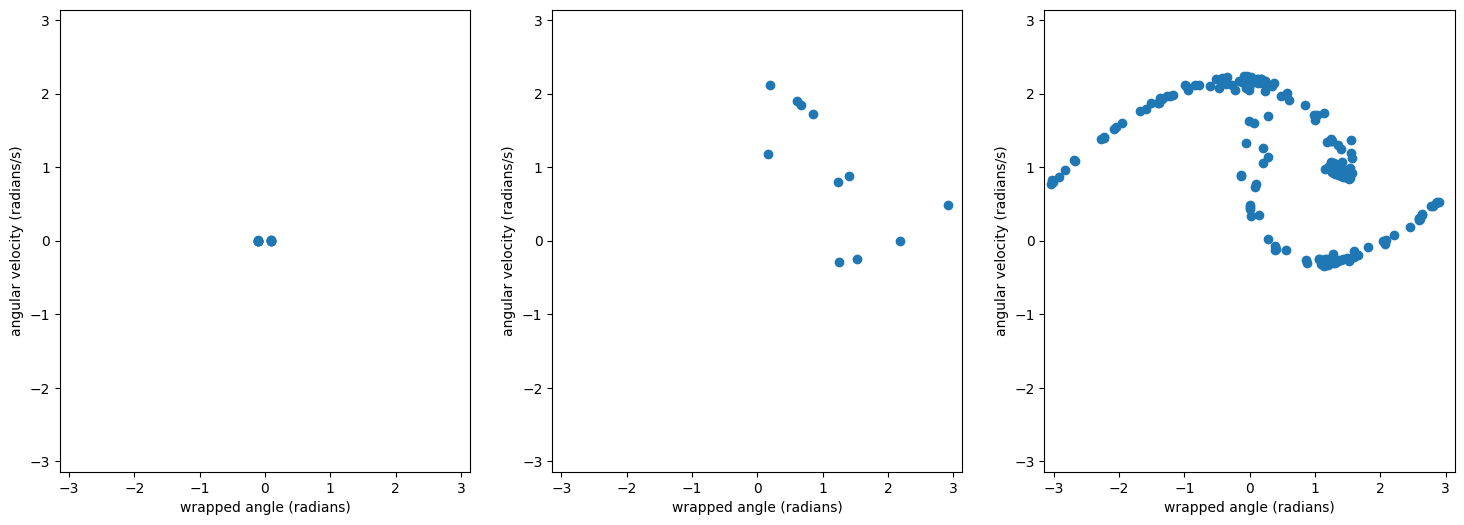

In [94]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
for i, case in enumerate(["linear", "twocycle", "chaos"]):
    ax[i].scatter(ptheta[case], pomega[case])
    ax[i].set_xlim(-np.pi, np.pi)
    ax[i].set_ylim(-np.pi, np.pi)
    ax[i].set_xlabel(r"wrapped angle (radians)")
    ax[i].set_ylabel(r"angular velocity (radians/s)")

## Toward bifurcation diagram

You need to be able to plot the Poincare section above as a function of a parameter. So, you need to "smoosh" across one axis. To do this, you really just need the 1-d vector `ptheta`, but then make a scatter plot all with the same $x$ axis value, $F_D$. 

Text(0, 0.5, '$\\theta_P$')

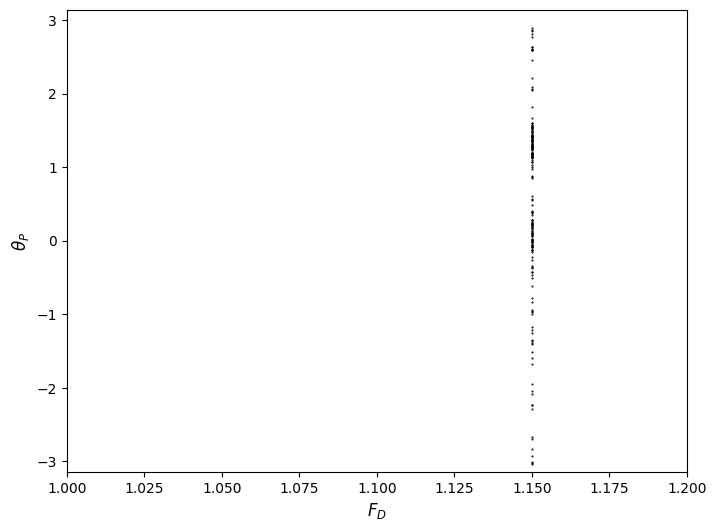

In [102]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
bif_xvals = np.full_like(ptheta["chaos"], pendul["chaos"].F_D )
ax.scatter(bif_xvals, ptheta["chaos"], color='k', marker='.', s=1)
ax.set_xlim(1.0, 1.2)
ax.set_ylim(-np.pi, np.pi)
ax.set_xlabel(r"$F_D$", fontsize="large")
ax.set_ylabel(r"$\theta_P$", fontsize="large")

Obviously, you need to vary the value and compute the appropriate Poincare map. 

## Bifurcation diagram

Here, you will use the $x-$ or $y-$ projection of the Poincare map to make a bifurcation diagram. You can then plot the projection as a function of various parameters. 

In [110]:
# You need to make a loop over interesting values of f_d. 
pendul2 = Pendulum(
    gamma = 0.5,
    omega_0 = 1.0, # natural frequency, not initial value!
    F_D = 1.0,
    omega_D = 2/3
)

# Example for one point
F_D = 1.1
pendul2.F_D = F_D
res = scipy.integrate.solve_ivp(fun = pendul2,
                                t_span = (0, 2000.),
                                y0 = [0., 0.], 
                                vectorized = True, 
                                atol = 1e-5, 
                                rtol = 1e-3,
                                method = "RK45",
                                first_step = 0.01)

## Your code goes here. 


In [157]:
# Note: this is a good use case for multiprocessing. Here is an example:
def some_func(x):
    # Dummy function
    time.sleep(1)
    return x, np.ones(10) * x

print("Test one call")
t1 = time.time()
some_func(0.)
t2 = time.time()
print(f"One call, T = {t2-t1} s")

print(f"cpu_count = {os.cpu_count()}")
nworkers = os.cpu_count() # or os.cpu_count()
with concurrent.futures.ProcessPoolExecutor(max_workers=nworkers) as executor:
    xlist = np.arange(0, 3*os.cpu_count(), 1)
    results = {}
    t1 = time.time()
    for x, result in executor.map(some_func, xlist):
        results[x] = result
    t2 = time.time()
    print(f"{len(xlist)} calls with {nworkers} workers: T = {t2-t1} s")
pprint(results)

Test one call
One call, T = 1.0037248134613037 s
cpu_count = 8
24 calls with 8 workers: T = 3.054633378982544 s
{np.int64(0): array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 np.int64(1): array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 np.int64(2): array([2., 2., 2., 2., 2., 2., 2., 2., 2., 2.]),
 np.int64(3): array([3., 3., 3., 3., 3., 3., 3., 3., 3., 3.]),
 np.int64(4): array([4., 4., 4., 4., 4., 4., 4., 4., 4., 4.]),
 np.int64(5): array([5., 5., 5., 5., 5., 5., 5., 5., 5., 5.]),
 np.int64(6): array([6., 6., 6., 6., 6., 6., 6., 6., 6., 6.]),
 np.int64(7): array([7., 7., 7., 7., 7., 7., 7., 7., 7., 7.]),
 np.int64(8): array([8., 8., 8., 8., 8., 8., 8., 8., 8., 8.]),
 np.int64(9): array([9., 9., 9., 9., 9., 9., 9., 9., 9., 9.]),
 np.int64(10): array([10., 10., 10., 10., 10., 10., 10., 10., 10., 10.]),
 np.int64(11): array([11., 11., 11., 11., 11., 11., 11., 11., 11., 11.]),
 np.int64(12): array([12., 12., 12., 12., 12., 12., 12., 12., 12., 12.]),
 np.int64(13): array([13., 13., 13.,